In [2]:
library(Seurat)
library(glue)
library(pheatmap)
library(RColorBrewer)
library(ggplot2)

In [3]:
obj_merged <- readRDS("/data/yuchen_data/Stereo_seq/All_Figures/allBcell.rds")

In [5]:
# set subtype gene set for Bcell
gs <- list()
gs[['NaiveB']] <- c('FCER2','CD72','BACH2','CD22','DEF8','FCRL1','IGHD','MCTP2','TCL1A')
gs[['GCB']] <- c('SUGCT','MME','AICDA','SERPINA9','AC023590.1','RGS13','SUSD3')
gs[['MemoryB']] <- c('FCRL4','TNFRSF13B','BANK1','BCL2A1','BHLHE40','BTNL9','COCH','GPR183','ITGAX','RASSF6','SAMSN1')
gs[['Plasma']] <- c('MZB1','JCHAIN','XBP1','DERL3','JSRP1','SSR4','SLAMF7')
subtype <- names(gs)
ntype <- length(subtype)

In [6]:
# compute the gene set score
obj_merged = AddModuleScore(obj_merged, gs)
for (i in 1:ntype) {
  obj_merged@meta.data[[subtype[i]]] = obj_merged@meta.data[[glue('Cluster{i}')]]
}
df_heatmap = obj_merged@meta.data[, subtype]

In [7]:
# scale the score
df_heatmap.scaled = scale(df_heatmap)
df_heatmap.scaled[df_heatmap.scaled > 4] = 4
df_heatmap.scaled[df_heatmap.scaled < -4] = -4
df_heatmap.scaled = t(df_heatmap.scaled)

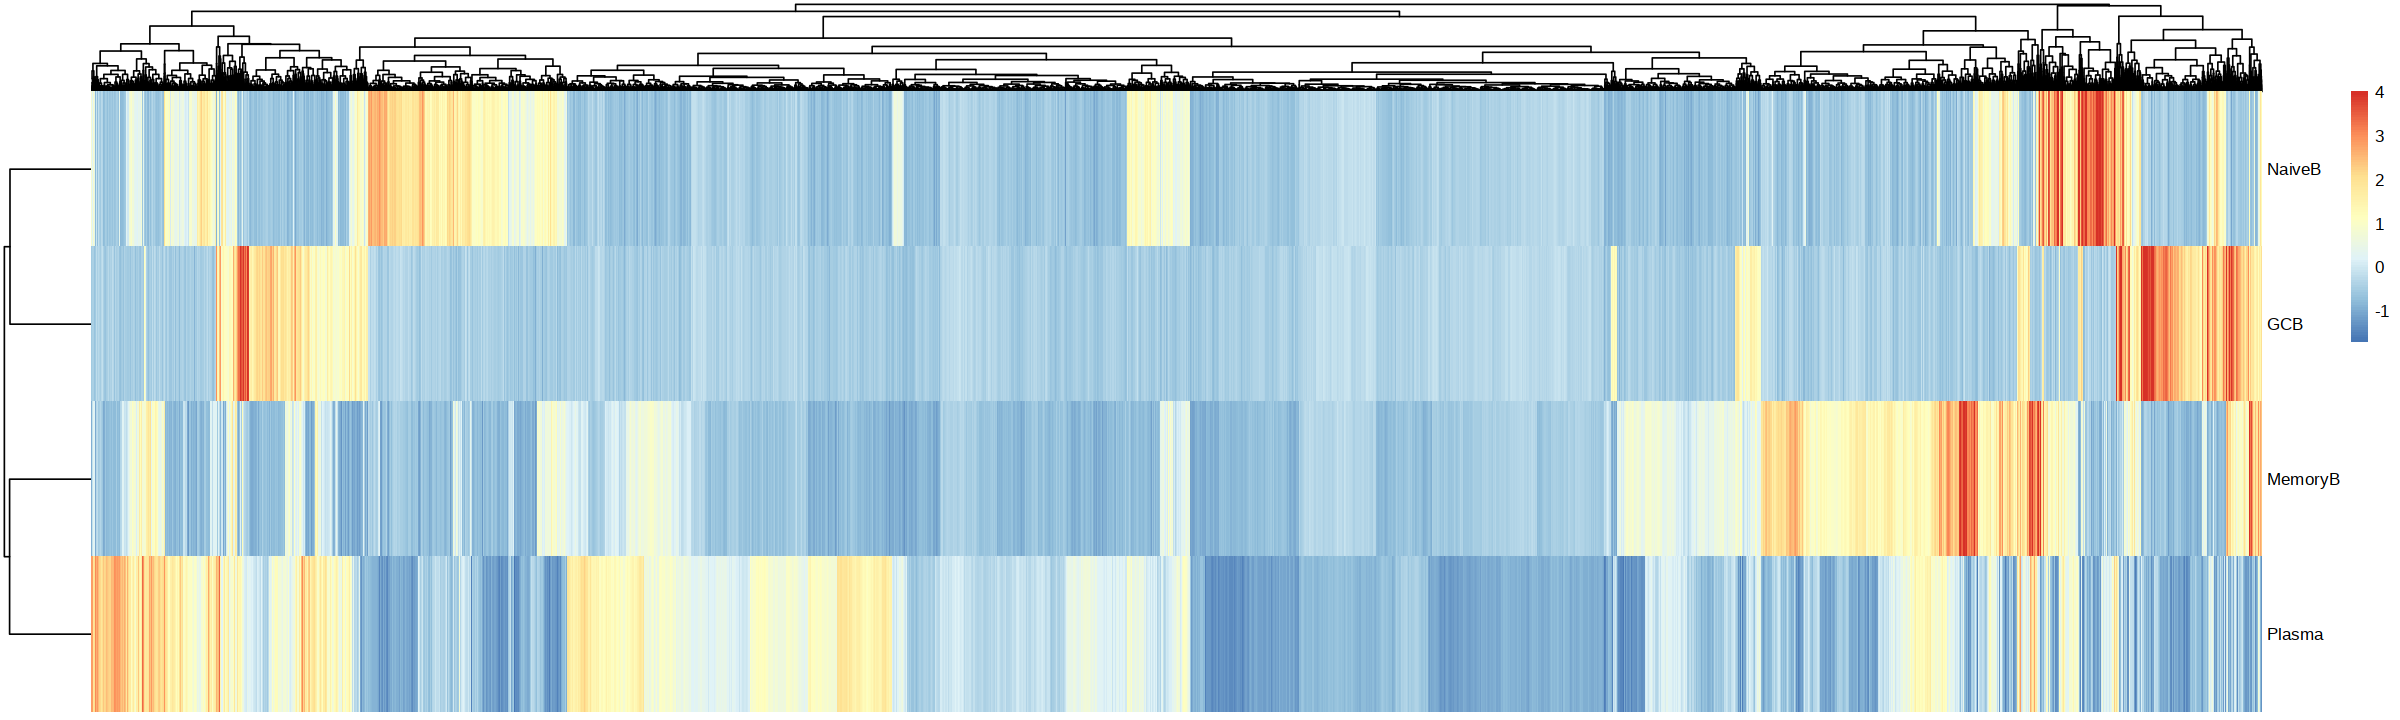

In [8]:
# Hierarchical clustering
options(repr.plot.width=20, repr.plot.height=6)
p = pheatmap(df_heatmap.scaled, cluster_rows=T, cluster_cols=T, show_colnames=F, scale='none')
col_order <- p$tree_col$order
df_sort <- df_heatmap.scaled[, col_order]

k_init = 200            # default classes is 200(classes must less than total number of cells)
col_cluster <- cutree(p$tree_col, k=k_init)            
tmp0 <- c()
for (i in colnames(df_sort)) {
  tmp0 <- c(tmp0, col_cluster[[i]])
}

df_anno = data.frame(row.names=colnames(df_sort), 'cluster'=tmp0)
df_anno$cluster = as.factor(df_anno$cluster)
# unique(df_anno$cluster)

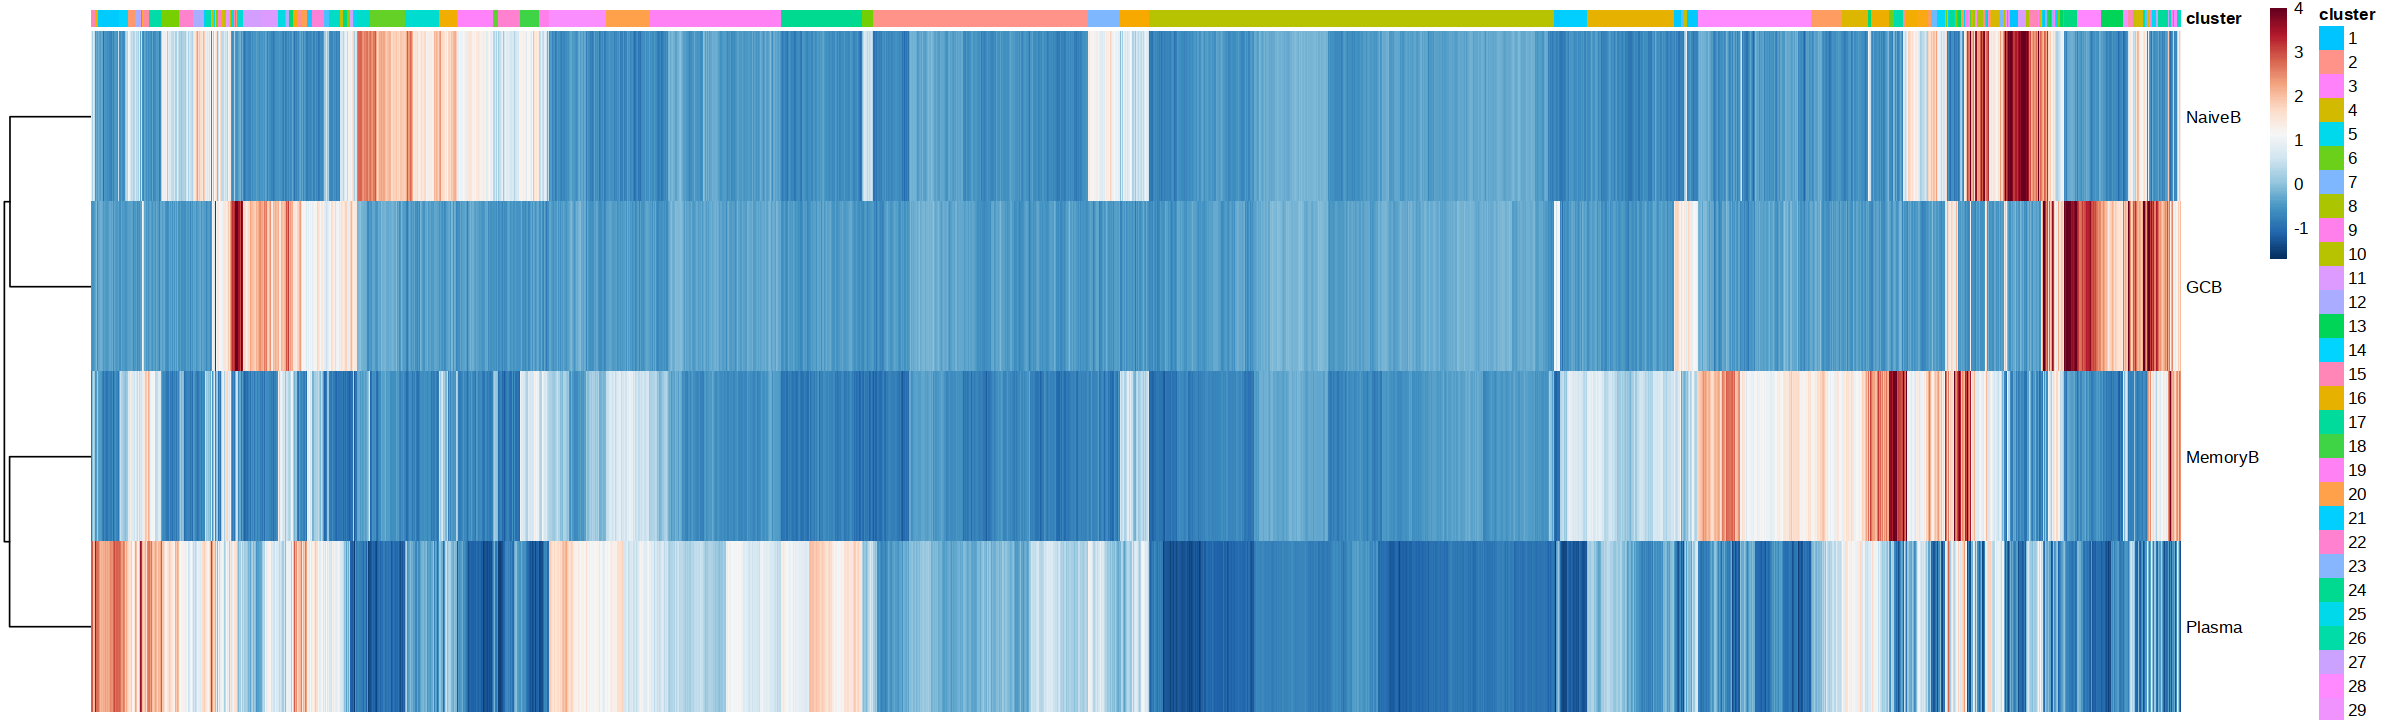

In [9]:
options(repr.plot.width=20, repr.plot.height=6)
pheatmap(df_sort, show_colnames=F, color=colorRampPalette(rev(brewer.pal(11,"RdBu")))(110), scale='none', 
               cluster_cols = F, annotation_col=df_anno)

In [10]:
# clustering with the mean value 
# init the cluster list
clusterindlist <- c()
for(stype in subtype){
    clusterindlist[[stype]] <- c(-1)
}
clusterindlist[['unknown']] <- c(-1)    # add the "unknown" class

In [11]:
# classify each group with the mean value 
for(jj in unique(df_anno$cluster)){
  flag <- df_anno$cluster == jj      
  subda <- df_sort[, flag]        

  # compute the mean of each cluster  
  su = c()
  if(sum(flag) > 1){
    for(si in 1:ntype){
        su <- c(su, sum(subda[si,]))
    }
    su <- su/sum(flag)
  } else {
    for(si in 1:ntype){
        su <- c(su, subda[si])
    }
  }

  # determine cluster by maximum value
  indjj <- which.max(su)
  if(max(su) > 0.05){      # set the cutoff of "unknown" class
    clusterindlist[[indjj]] <- c(clusterindlist[[indjj]], as.numeric(jj))
  } else {
    clusterindlist[[ntype+1]] <- c(clusterindlist[[ntype+1]], as.numeric(jj))
  }
}

In [12]:
# combine bin index of each cluster
NaiveB_bin <- c(colnames(df_sort)[tmp0 %in% clusterindlist$NaiveB])
NaiveB_bin_sorted <- NaiveB_bin[order(df_heatmap.scaled['NaiveB', NaiveB_bin], decreasing=T)]

GCB_bin <- c(colnames(df_sort)[tmp0 %in% clusterindlist$GCB])
GCB_bin_sorted <- GCB_bin[order(df_heatmap.scaled["GCB", GCB_bin], decreasing=T)]

MemoryB_bin <- c(colnames(df_sort)[tmp0 %in% clusterindlist$MemoryB])
MemoryB_bin_sorted <- MemoryB_bin[order(df_heatmap.scaled['MemoryB', MemoryB_bin], decreasing=T)]

Plasma_bin <- c(colnames(df_sort)[tmp0 %in% clusterindlist$Plasma])
Plasma_bin_sorted <- Plasma_bin[order(df_heatmap.scaled['Plasma', Plasma_bin], decreasing=T)]

bunknown_bin <- colnames(df_sort)[tmp0 %in% clusterindlist$unknown]

bin_sorted <- c(NaiveB_bin_sorted, GCB_bin_sorted, MemoryB_bin_sorted, Plasma_bin_sorted, bunknown_bin)
df_heatmap.scaled <- df_heatmap.scaled[c('NaiveB', 'GCB', 'MemoryB', 'Plasma'), bin_sorted]

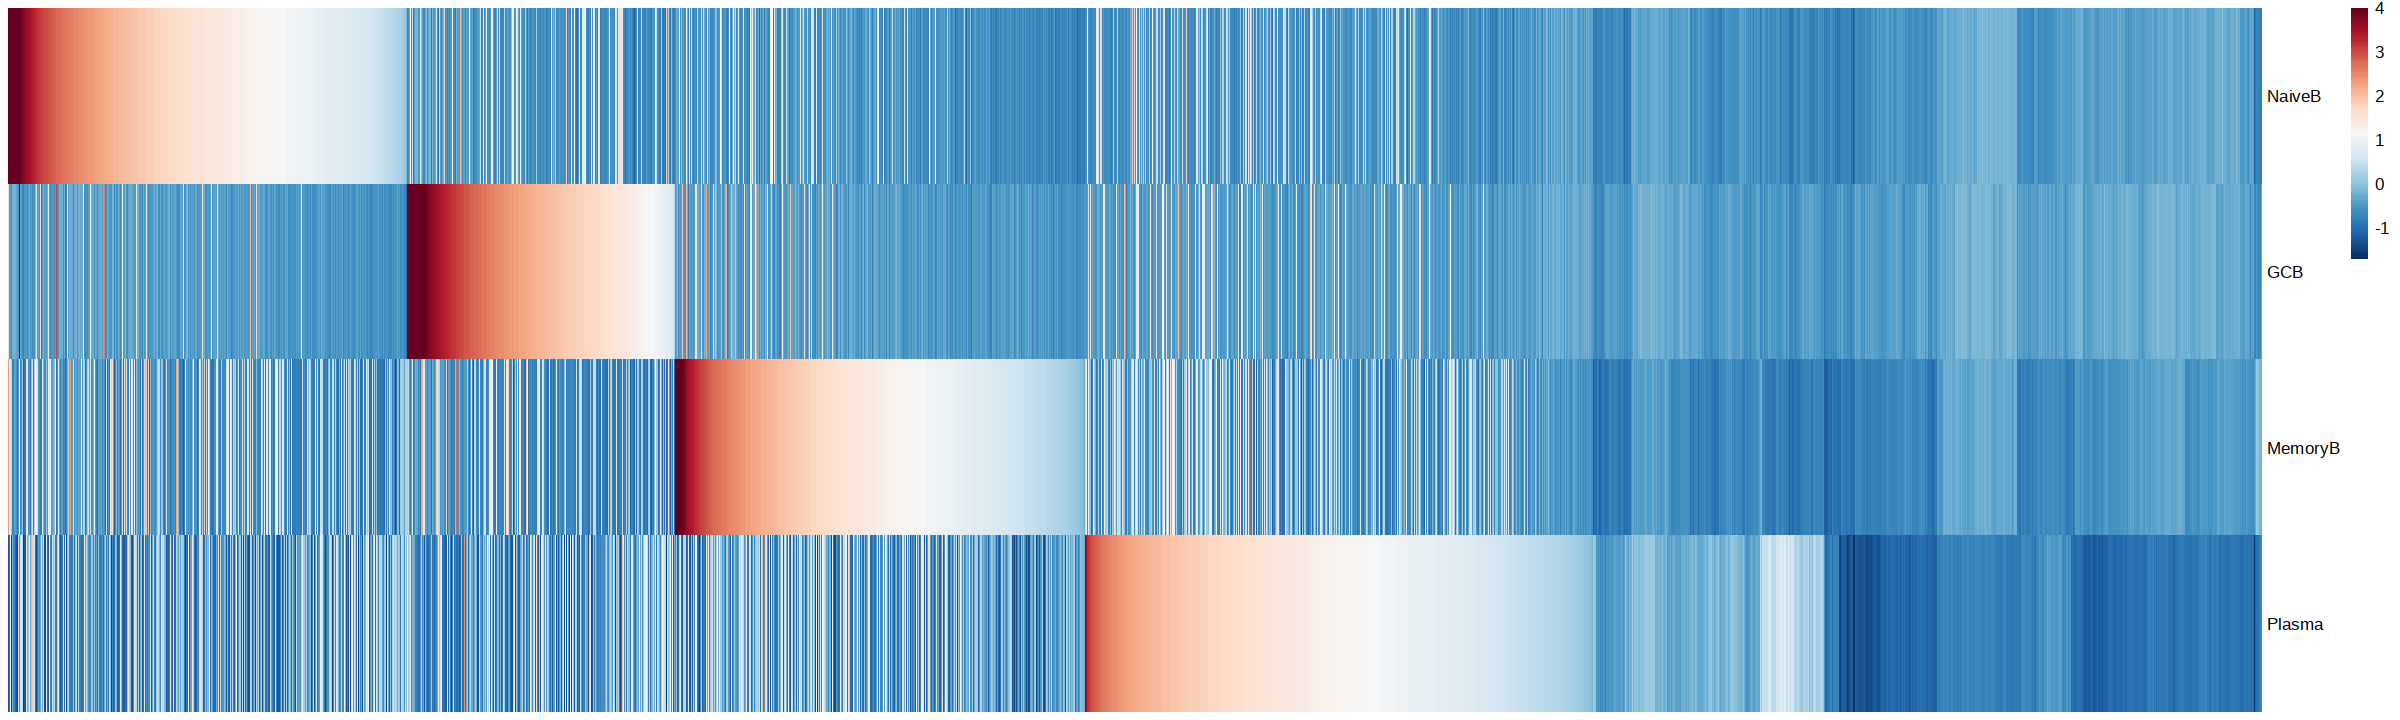

In [13]:
options(repr.plot.width=20, repr.plot.height=6)
pheatmap(df_heatmap.scaled, show_colnames=F, color=colorRampPalette(rev(brewer.pal(11,"RdBu")))(110), scale='none', 
               cluster_cols = F, cluster_rows = F)
# It is important to note that if not achieve the expected result, a more stringent threshold should be needed in the first round of clustering, and then repeat iterations for the "unknown" category

In [55]:
# save labels
df_anno = data.frame(row.names=bin_sorted)
df_anno['Cluster_rst'] = ''
df_anno[NaiveB_bin,'Cluster_rst'] = 'NaiveB'
df_anno[GCB_bin,'Cluster_rst'] = 'GCB'
df_anno[MemoryB_bin,'Cluster_rst'] = 'MemoryB'
df_anno[Plasma_bin,'Cluster_rst'] = 'Plasma'
df_anno[bunknown_bin,'Cluster_rst'] = 'B_Other'

samplelist = rownames(df_anno)
samplelist = samplelist[order(samplelist)]
df_anno_all = data.frame(row.names=samplelist, celltype=df_anno[samplelist,])
write.table(df_anno_all, 'Bcell.rst.txt', sep='\t', quote=F)

# add metadata
obj_merged@meta.data[rownames(df_anno_all),'CellSubType'] <- df_anno_all$celltype
obj_merged$CellSubType = factor(obj_merged$CellSubType, levels=c('GCB', 'NaiveB', 'MemoryB', 'Plasma', 'B_Other'))

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


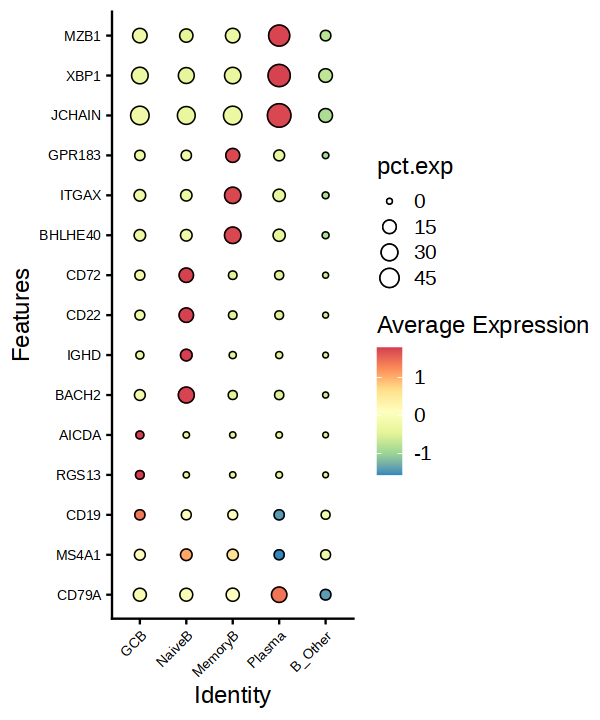

In [58]:
# select the gene to plot dotplot
plot_genes_selected <- c('CD79A', 'MS4A1', 'CD19', 'RGS13', 'AICDA', 'BACH2', 'IGHD', 'CD22', 'CD72', 'BHLHE40', 'ITGAX', 'GPR183', 'JCHAIN', 'XBP1', 'MZB1')
options(repr.plot.width=5, repr.plot.height=6)
DotPlot(obj_merged, features = plot_genes_selected, group.by='CellSubType', cols='Spectral') + coord_flip() + 
    geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) + 
    guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white"))) + 
    scale_size(breaks = c(0, 15, 30, 45)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=8), axis.text.y = element_text(size=8))